# EDA and Modeling of Housing Prices in Ames, IA Using Regularized Regressions

The research question of interest is to accurately predict a house's sale price in Ames, IA. The resulting model can be used by buyers, sellers, and realtors to obtain an estimate of what a house is worth. 

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import skew

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sn

## Functions

In [2]:
def chart_gen(chart, bucket, col, df, features, target = None):
    """
    Uses the parameters to generate charts
    Parameters:
        chart (string): Chart type, options are hist, bar, and scatter
        bucket (int): if hist is chosen, the number of bins must be selected. If hist is not chosen,
        any value will work.
        col (int): number of charts to be in a single grid row for presentation purposes
        df (DataFrame): dataframe that the series are derived from
        features (list): list of features to be charted 
        target (string): name of target variable for scatter plot
    Returns:
        charts for the features chosen unless an incorrect chart name is given. Then a message
        requests the user to use a valid chart name.
    """
    if chart == 'hist':
        COUNT = 0
        fig = plt.figure(figsize=(25, 5))
        gs = GridSpec(nrows=1, ncols=col)

        for i in features:
            ax = fig.add_subplot(gs[0, COUNT])
            ax.hist(df[i], bins=bucket)
            plt.title("Histogram of " + str(i) + " Values")
            COUNT += 1

        plt.show()    
    
    elif chart == 'bar':
        COUNT = 0
        fig = plt.figure(figsize=(25, 5))
        gs = GridSpec(nrows=1, ncols=col)

        for i in features:
            counts = df[i].value_counts().sort_values()
            ax = fig.add_subplot(gs[0, COUNT])
            ax.bar(counts.index, counts)
            plt.xticks(rotation='vertical')
            plt.title("Histogram of " + str(i) + " Values")
            COUNT += 1
    
        plt.show()
        
    elif chart == 'box':
        COUNT = 0
        fig = plt.figure(figsize=(25, 5))
        gs = GridSpec(nrows=1, ncols=col)

        for i in features:
            ax = fig.add_subplot(gs[0, COUNT])
            ax.boxplot(df[i])
            plt.ylabel("Boxplot of " + str(i) + " Values")
            COUNT += 1
        
        fig.tight_layout()
        plt.show()
        
    elif chart == 'scatter':
        COUNT = 0
        fig = plt.figure(figsize=(25, 5))
        gs = GridSpec(nrows=1, ncols=col)

        for i in features:
            ax = fig.add_subplot(gs[0, COUNT])
            ax.scatter(df[i], df[target])
            plt.title("Scatter plot of " + str(i) + " and " + str(target))
            COUNT += 1
        
        fig.tight_layout()
        plt.show()
        
    elif chart == 'scatter-string':
        COUNT = 0
        fig = plt.figure(figsize=(25, 5))
        gs = GridSpec(nrows=1, ncols=col)

        for i in features:
            x_names = df[i].astype('category').drop_duplicates()
            x_values = df[i].astype('category').cat.codes
            ax = fig.add_subplot(gs[0, COUNT])
            ax.scatter(x_values, df[target])
            ax.set_xticks(range(0, len(x_names)))
            ax.set_xticklabels(list(x_names))
            plt.title("Scatter plot of " + str(i) + " and " + str(target))
            COUNT += 1
        
        fig.tight_layout()
        plt.show()
         
    else:
        return print('Please choose a valid chart type: hist, bar, box, scatter, or scatter-string')

## Ingest

In [3]:
train = pd.read_csv('https://raw.githubusercontent.com/jhancuch/housing-regularized-regression-models/main/data/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/jhancuch/housing-regularized-regression-models/main/data/test.csv')

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
print(train.columns)
print(train.shape)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
print(test.columns)
print(test.shape)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## EDA

Conduct EDA / preprocessing with the train and test set combined in order to provide better imputation due to the small n size of each data set.

In [102]:
combined = train.append(test).reset_index(drop=True)
print(combined.shape)

(2919, 81)


### Dependent and Independent Variable Distributions

#### Dependent Variable

Commentary here

Dependent Variable Summary Statistics:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Dependent Variable Median: 163000.0
Dependent Variable Mean: 180921.0

Skew statistic : nan


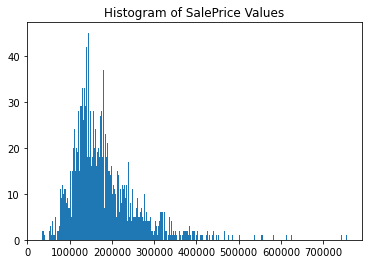

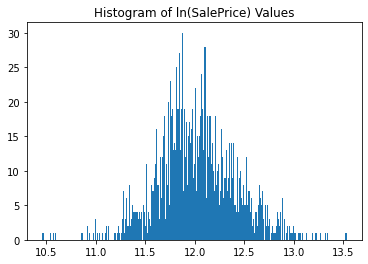

In [103]:
print('Dependent Variable Summary Statistics:\n{0}\n'.format(combined['SalePrice'].describe()))
print('Dependent Variable Median: {0}'.format(round(combined['SalePrice'].median(), 0)))
print('Dependent Variable Mean: {0}\n'.format(round(combined['SalePrice'].mean(), 0)))
print('Skew statistic : {0}'.format(skew(combined['SalePrice'])))

plt.hist(combined['SalePrice'], bins = 300)
plt.title("Histogram of SalePrice Values")
plt.show()

plt.hist(np.log(combined['SalePrice']), bins = 300)
plt.title("Histogram of ln(SalePrice) Values")
plt.show()

combined['SalePriceLn'] = np.log(combined['SalePrice'])

#### Independent Variables

Plot the histograms of numerical variables. There appears to be potential outliers with LotArea, MasVnrArea, BsmtFinSF1, BsmtFinSF2, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GarageYrBuilt, WoodDeckSF, OpenPorchSF, and EnclosedPorch which might be miscoded. Will examine these during Preprocessing.

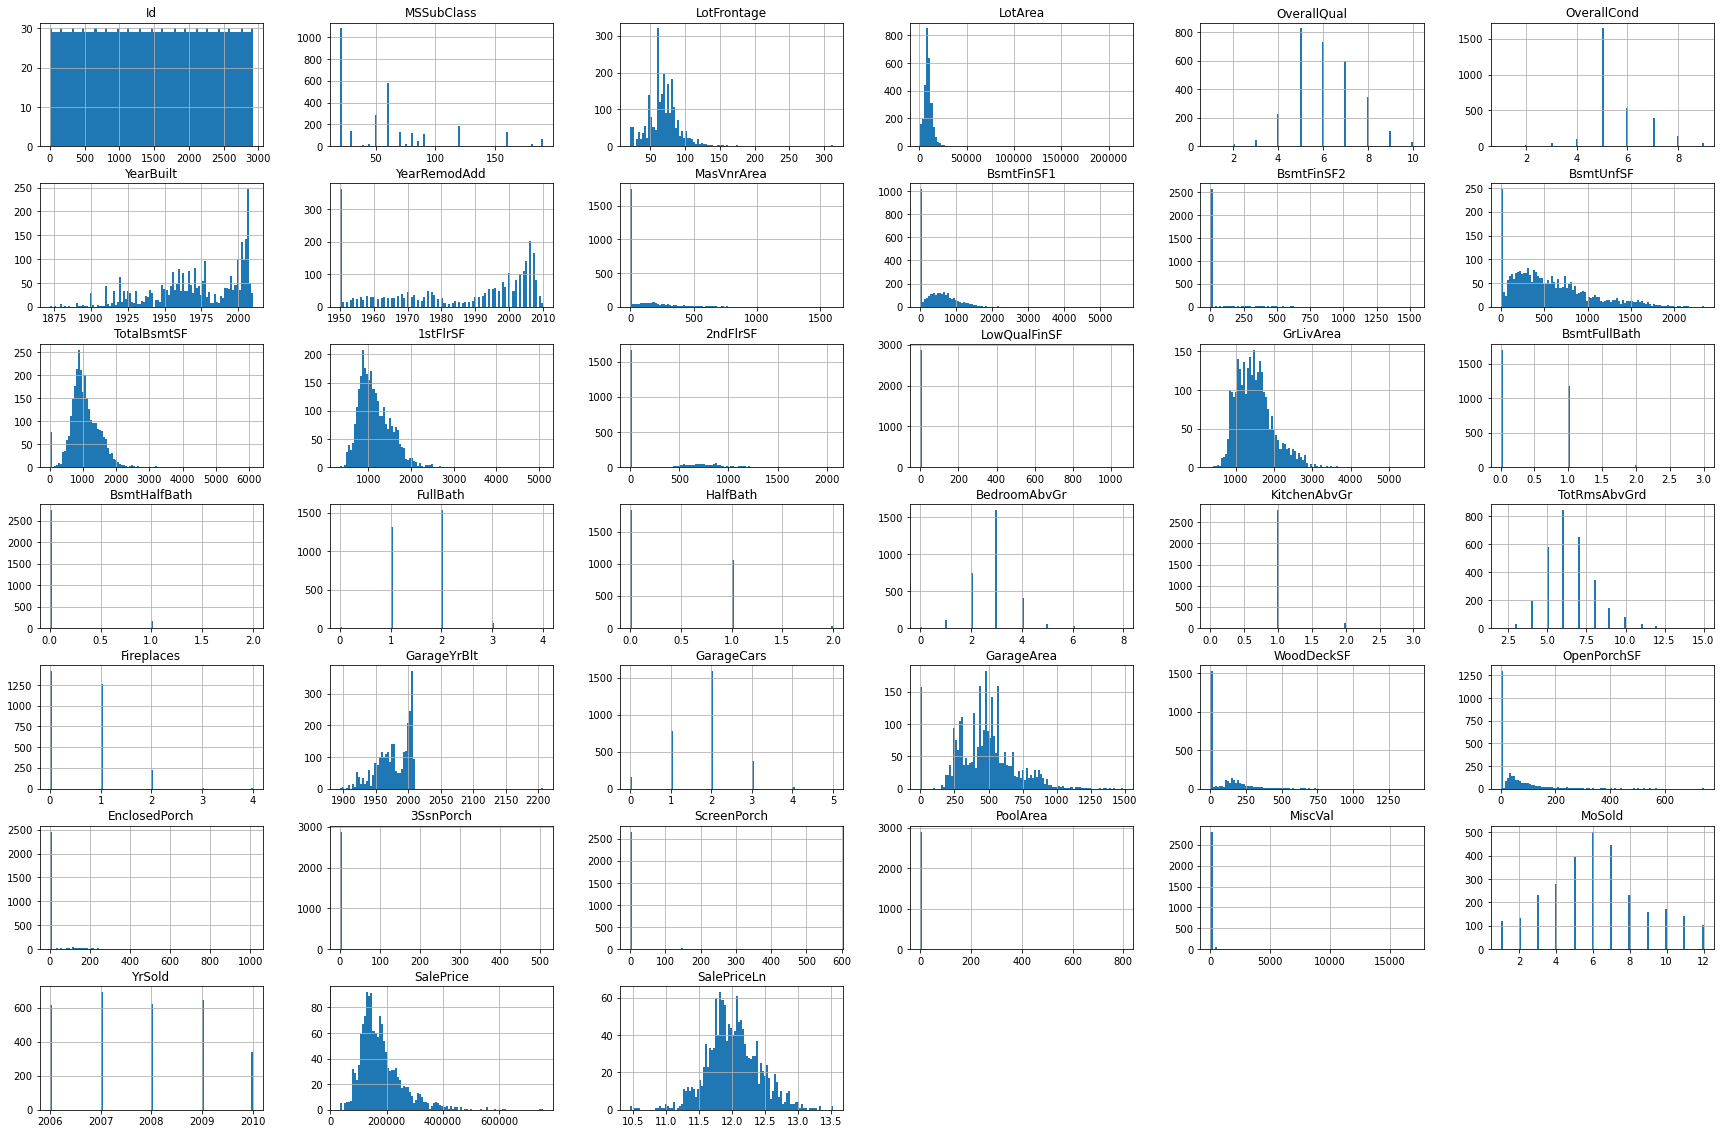

In [10]:
combined.hist(bins = 100, figsize = (30, 20))
plt.show()

Plot categorical variables

In [11]:
cat_vars = ['BsmtFullBath', 'BsmtHalfBath', 'MoSold', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'YrSold',
            'GarageCars', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Neighborhood',
            'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 
            'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
            'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 
            'MiscFeature', 'SaleType', 'SaleCondition', 'GarageYrBlt', 'MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd']

##### Output

BsmtFullBath


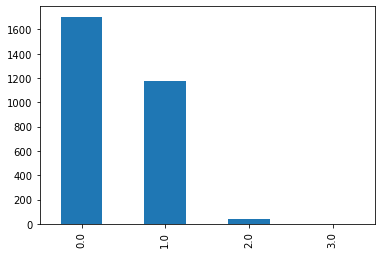

BsmtHalfBath


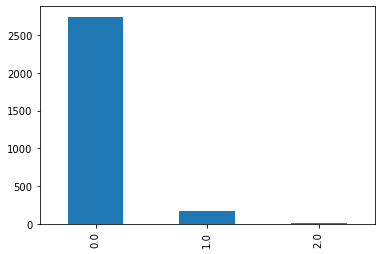

MoSold


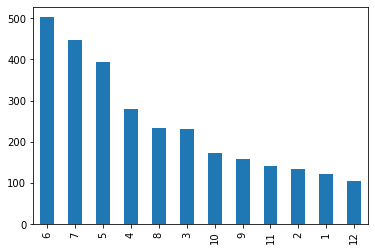

FullBath


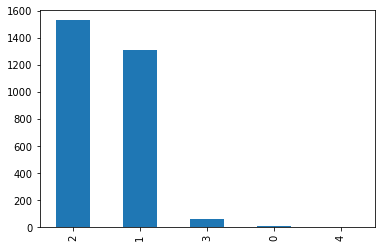

HalfBath


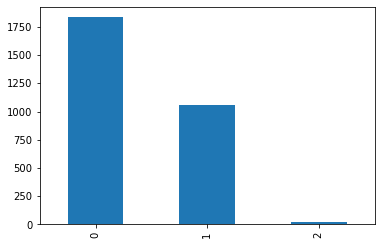

BedroomAbvGr


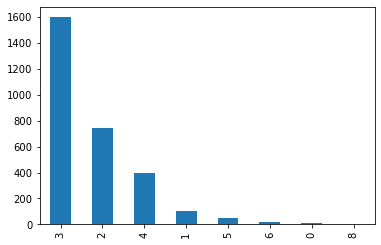

KitchenAbvGr


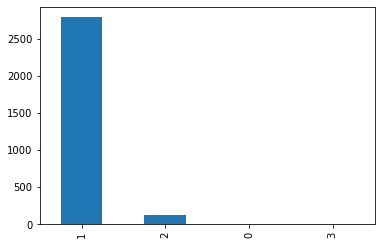

TotRmsAbvGrd


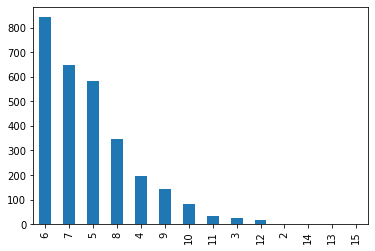

Fireplaces


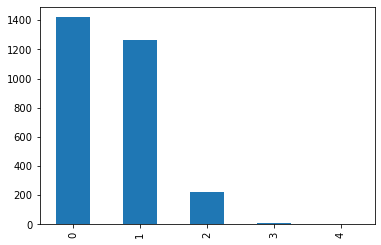

YrSold


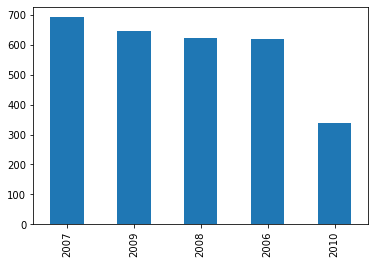

GarageCars


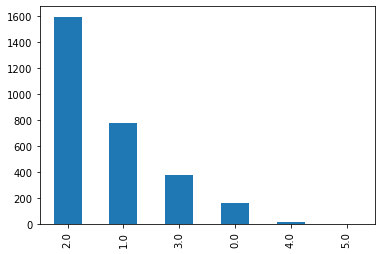

MSZoning


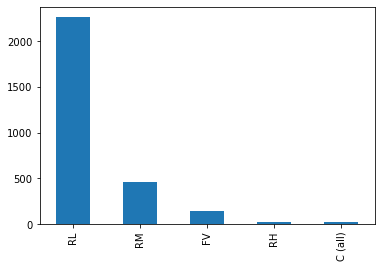

Street


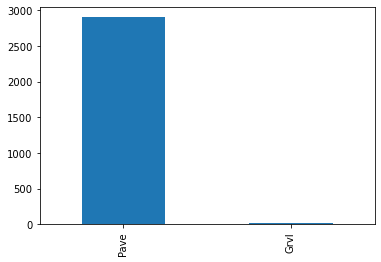

Alley


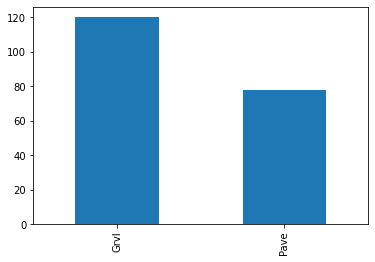

LotShape


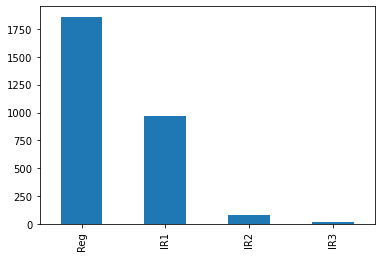

LandContour


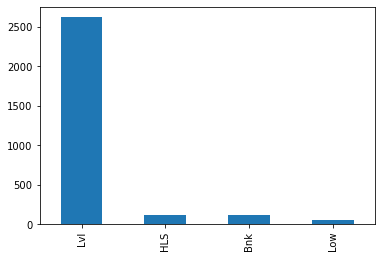

Utilities


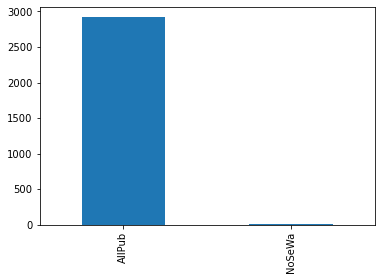

LotConfig


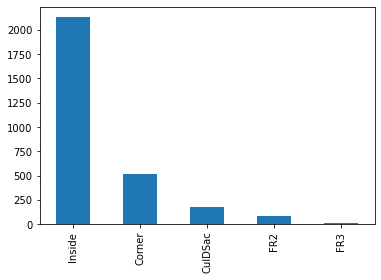

LandSlope


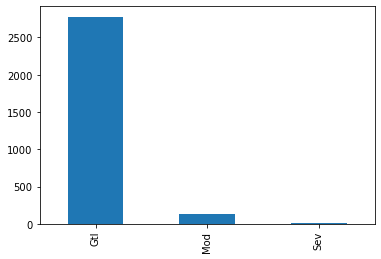

Condition1


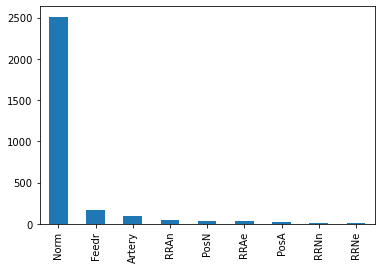

Neighborhood


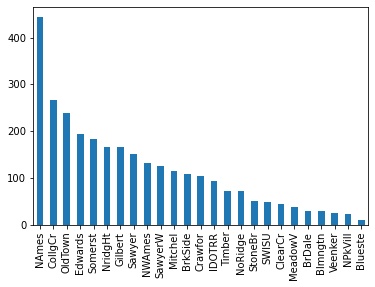

Condition2


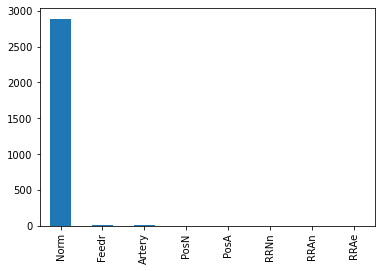

BldgType


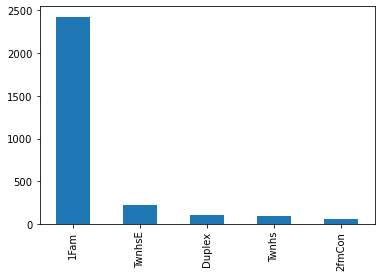

HouseStyle


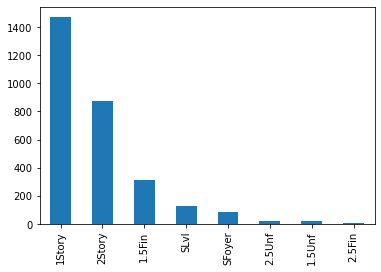

RoofStyle


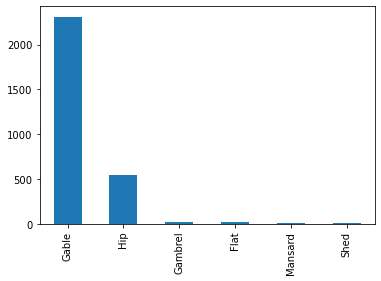

RoofMatl


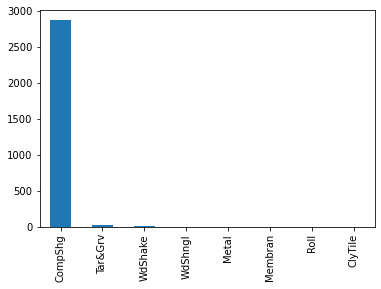

Exterior1st


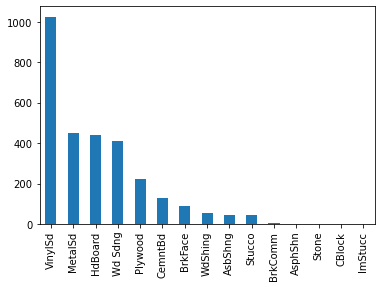

Exterior2nd


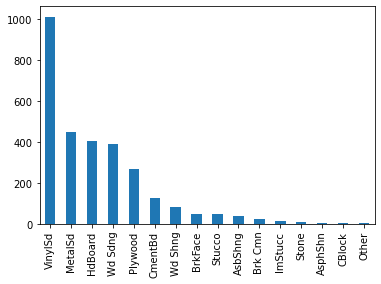

MasVnrType


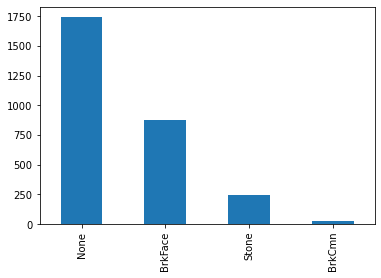

ExterQual


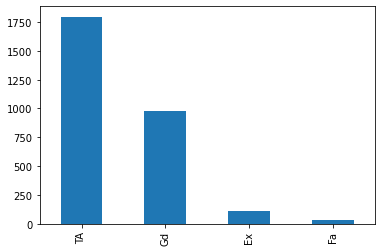

ExterCond


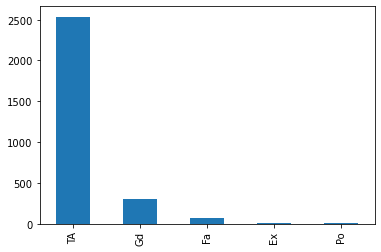

Foundation


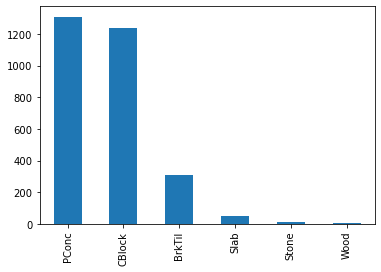

BsmtQual


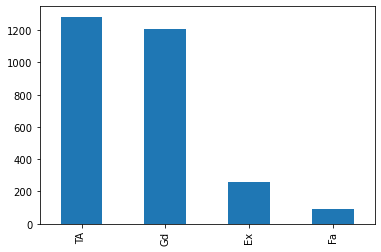

BsmtCond


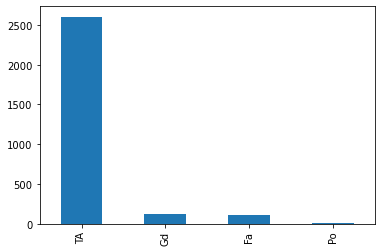

BsmtExposure


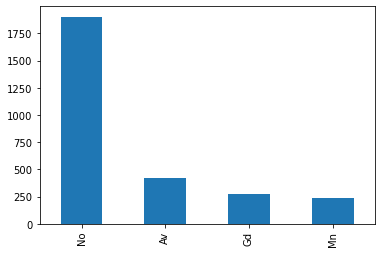

BsmtFinType1


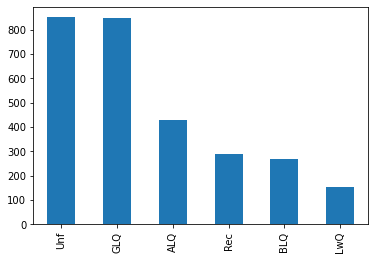

BsmtFinType2


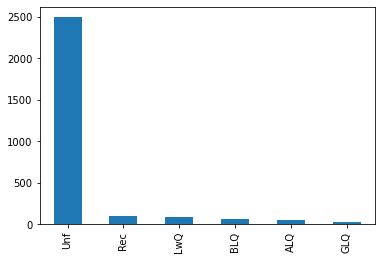

Heating


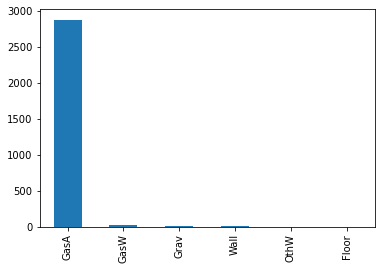

HeatingQC


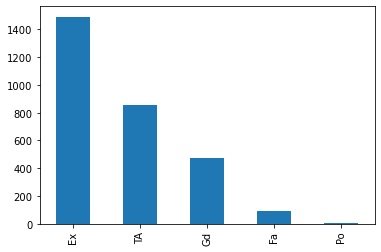

CentralAir


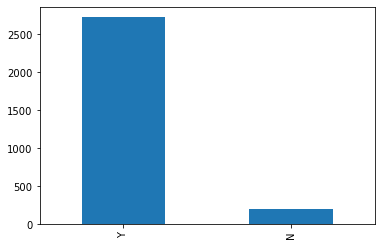

Electrical


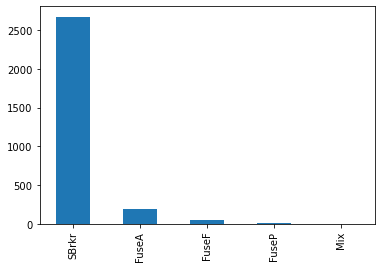

KitchenQual


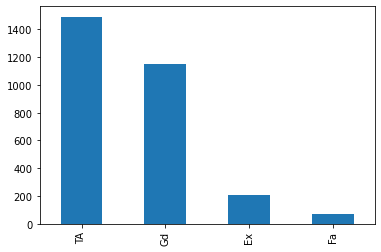

Functional


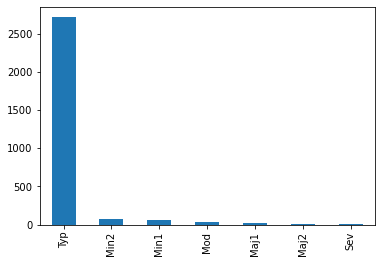

FireplaceQu


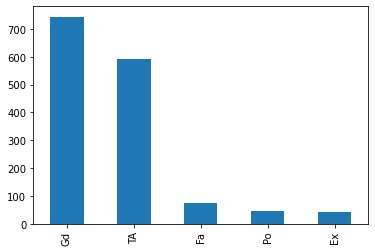

GarageType


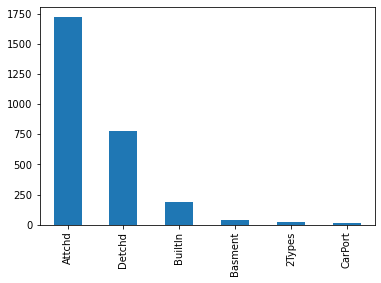

GarageFinish


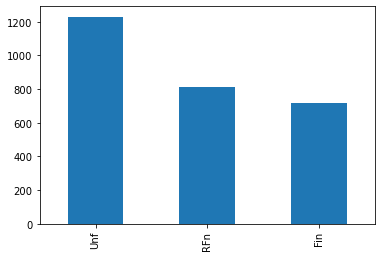

GarageQual


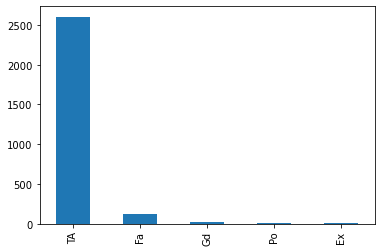

GarageCond


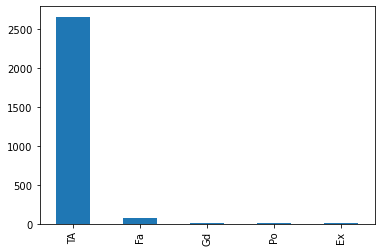

PavedDrive


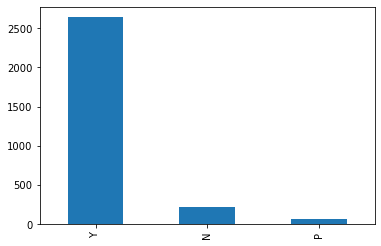

PoolQC


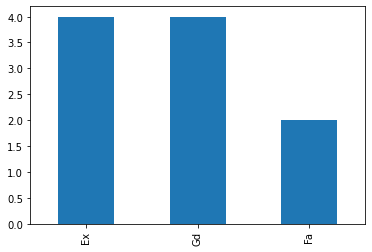

Fence


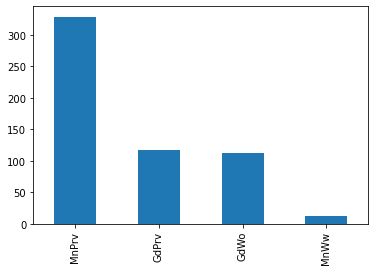

MiscFeature


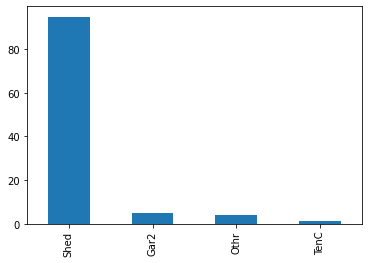

SaleType


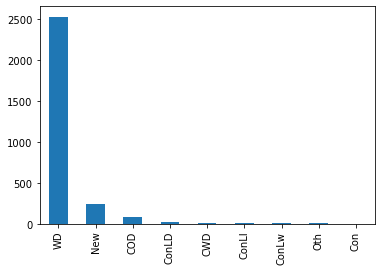

SaleCondition


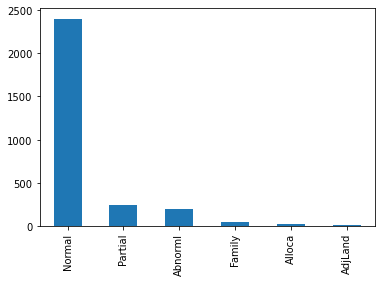

GarageYrBlt


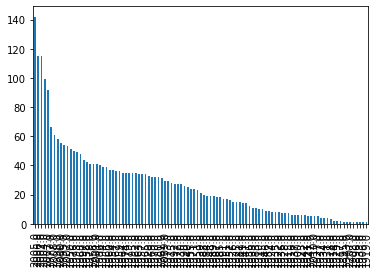

MSSubClass


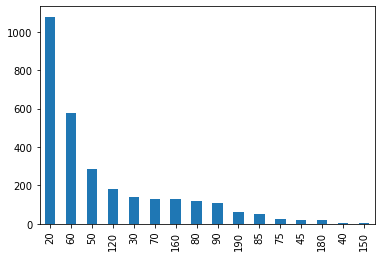

OverallQual


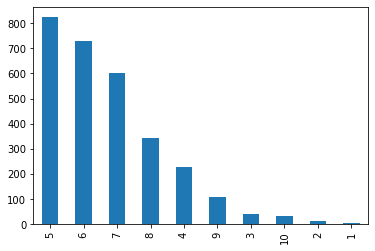

OverallCond


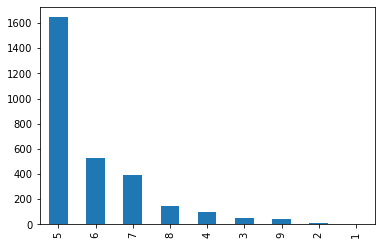

YearBuilt


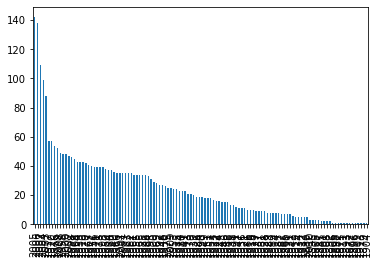

YearRemodAdd


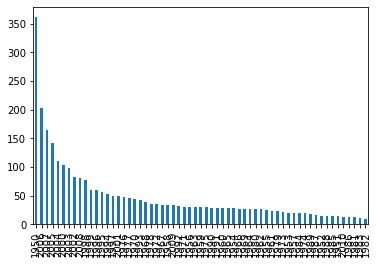

In [12]:
for i in cat_vars:
    print(i)
    combined[i].value_counts().plot.bar()
    plt.show()

### Relationship between SalePriceLn and Independent Variables

commentary 

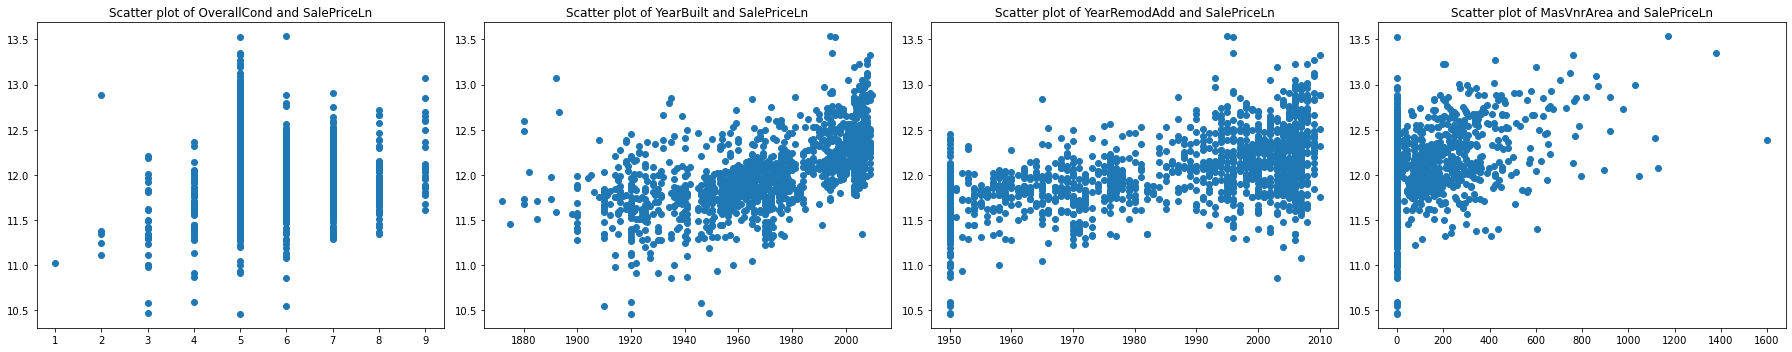

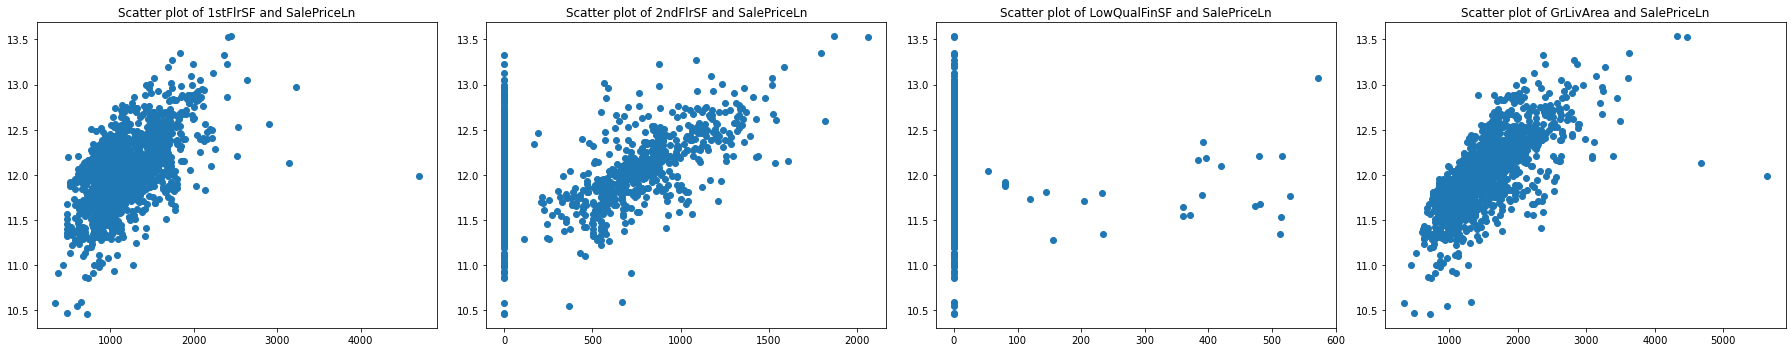

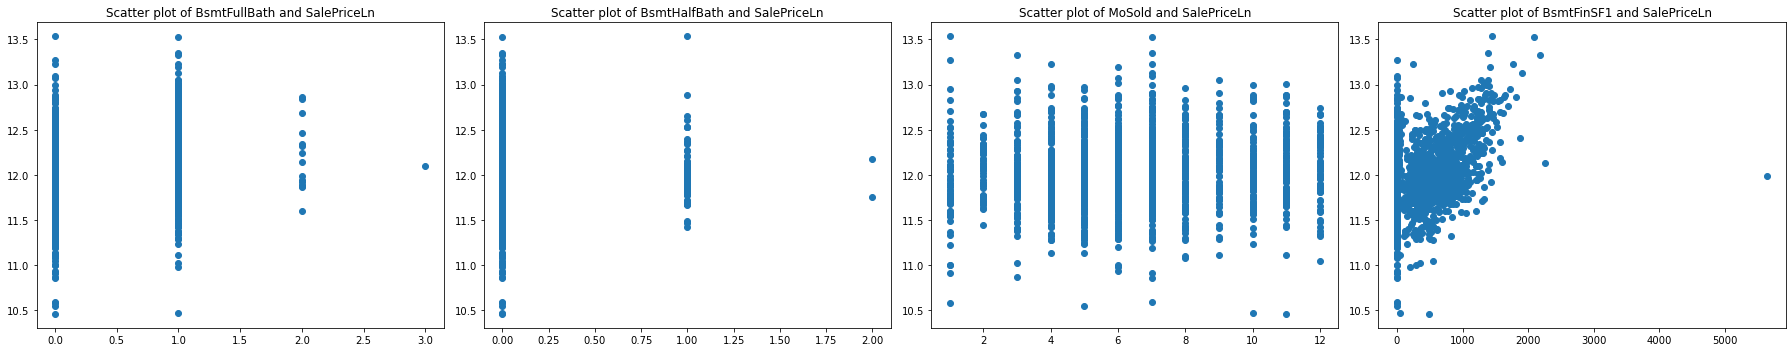

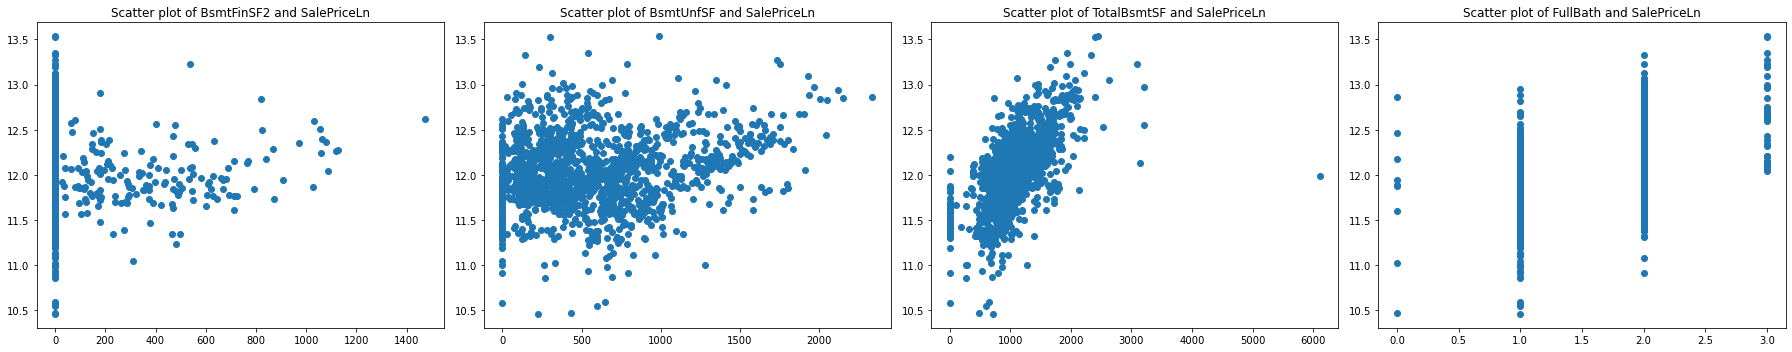

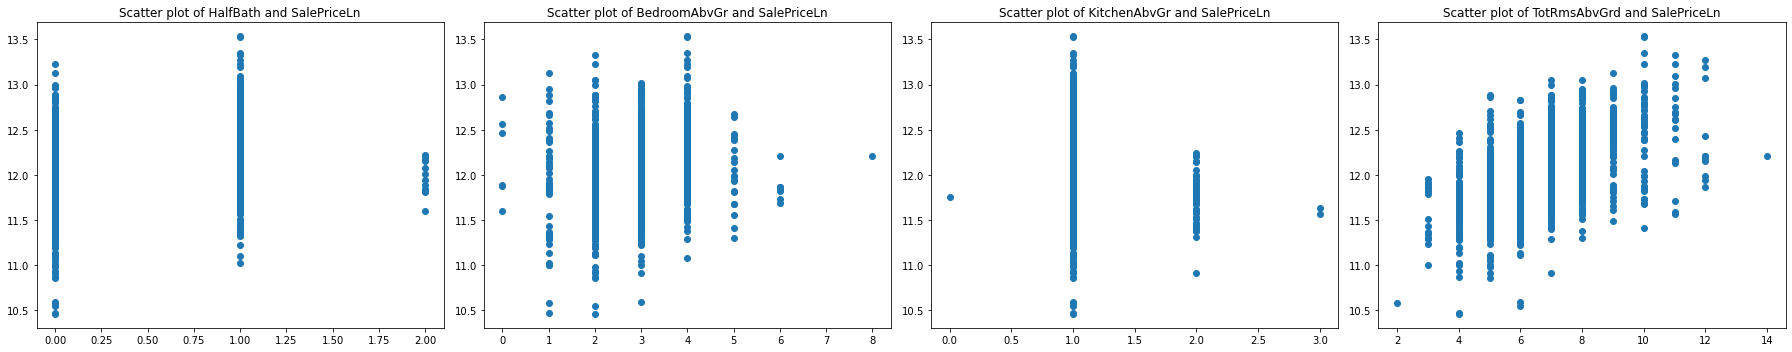

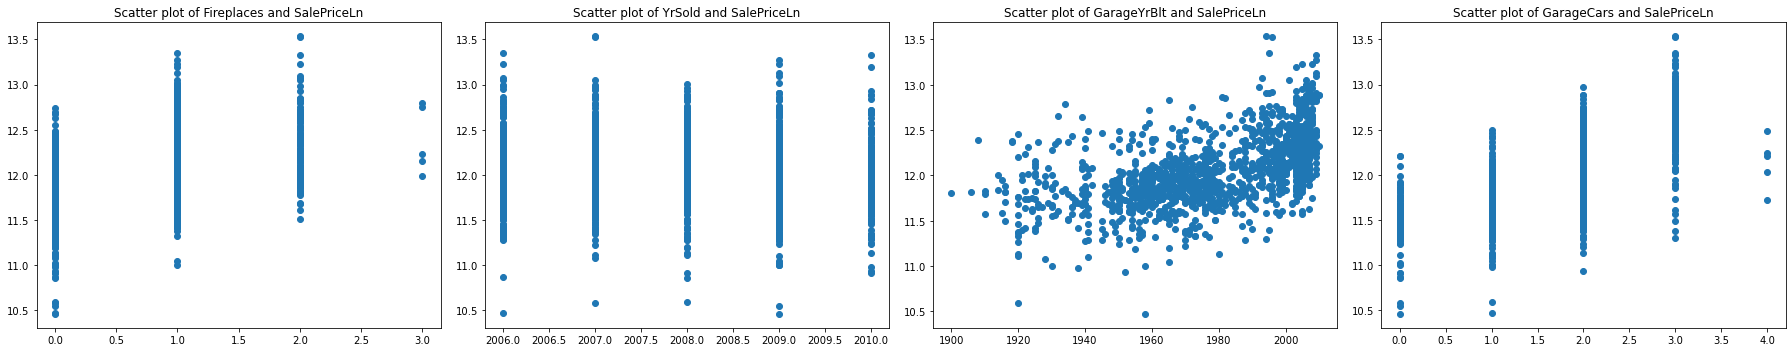

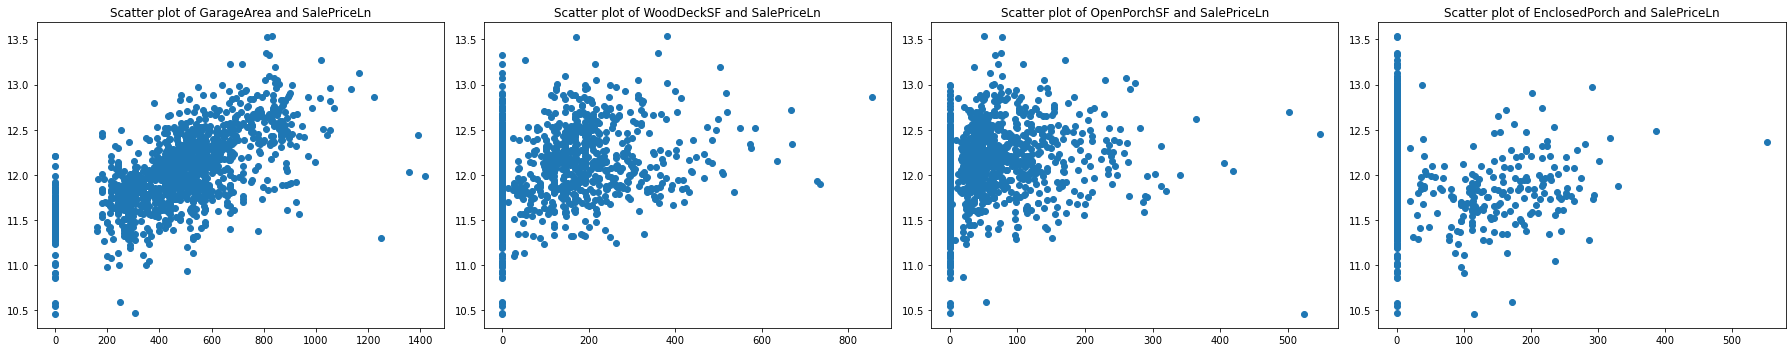

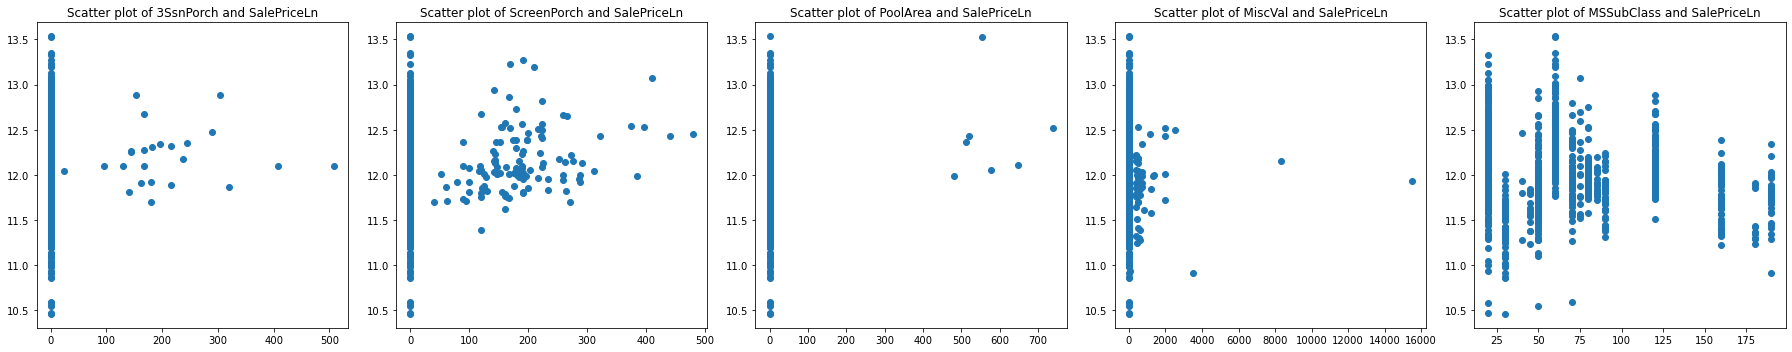

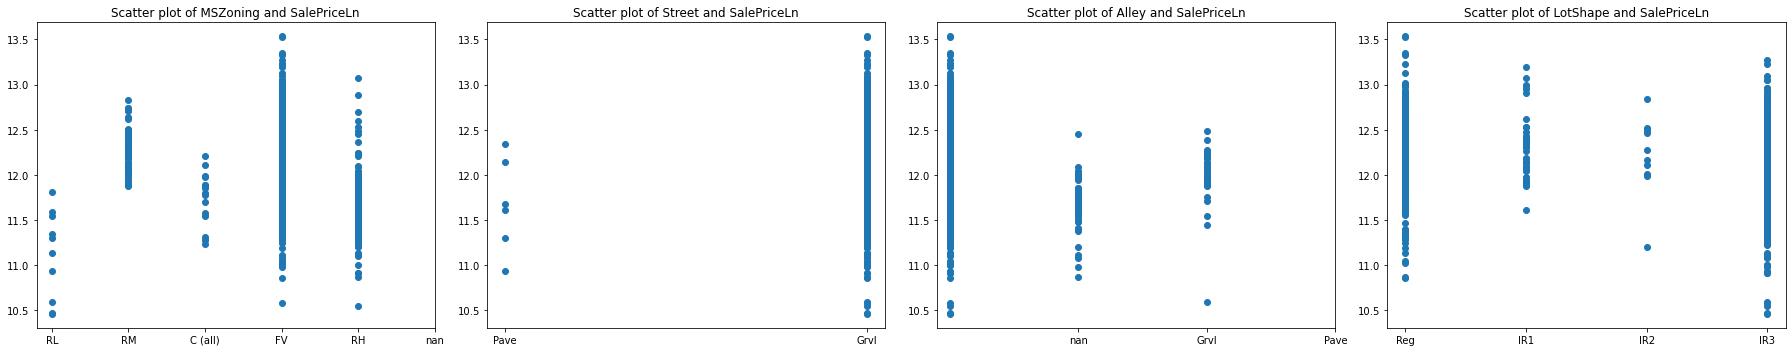

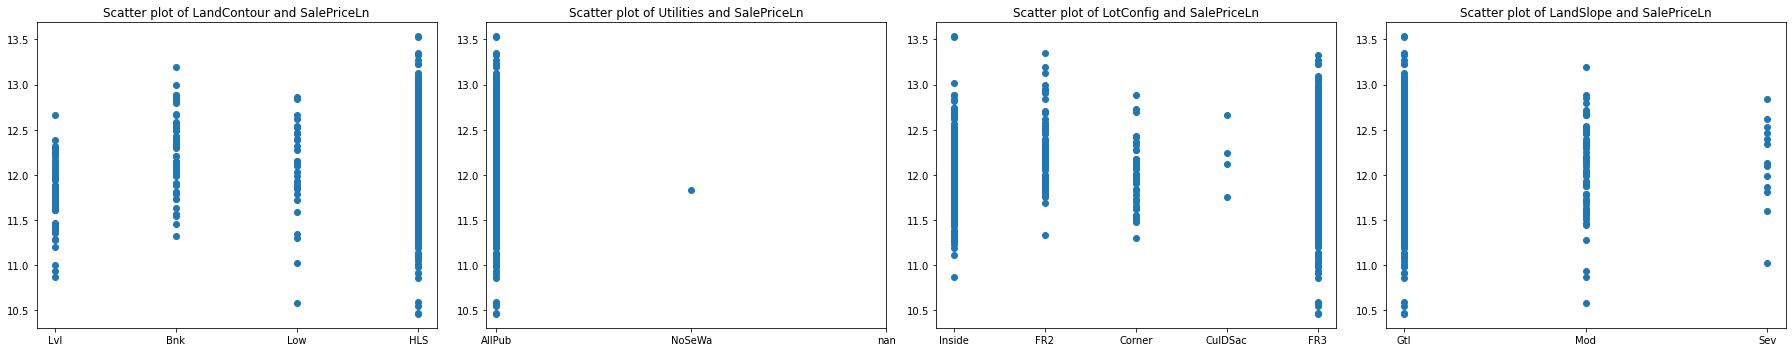

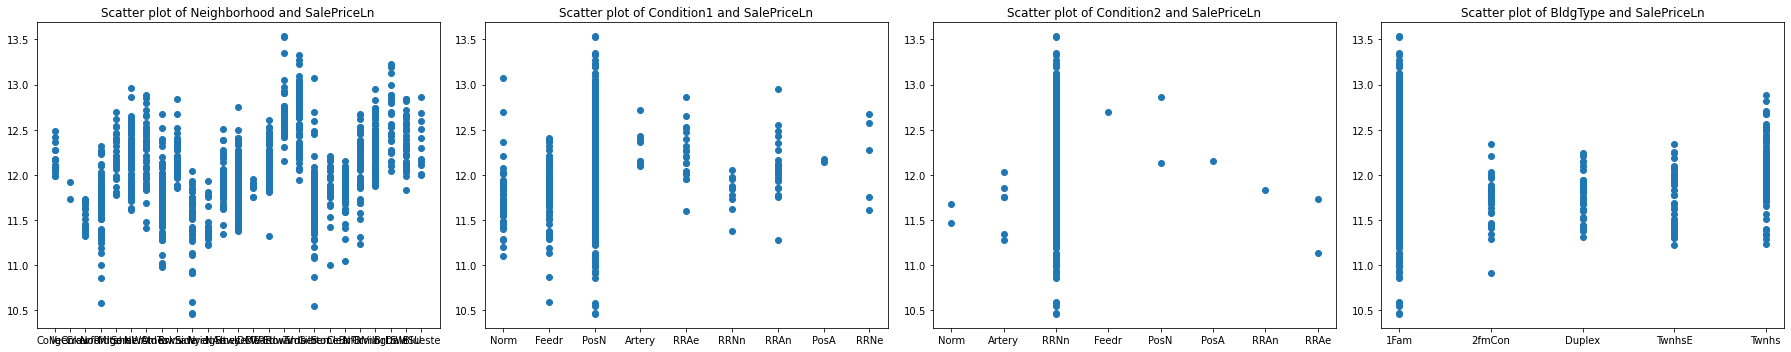

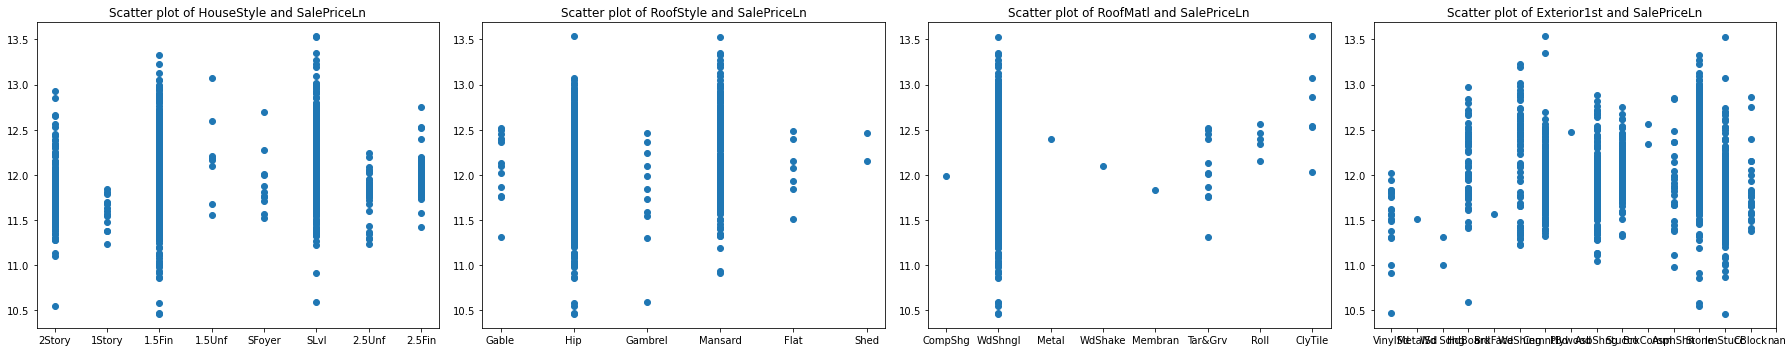

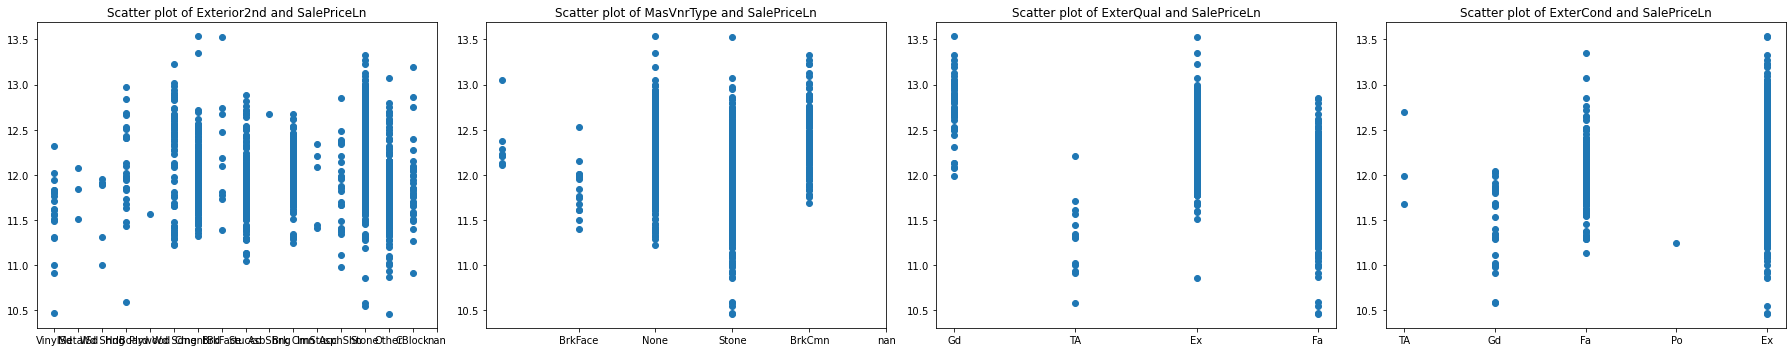

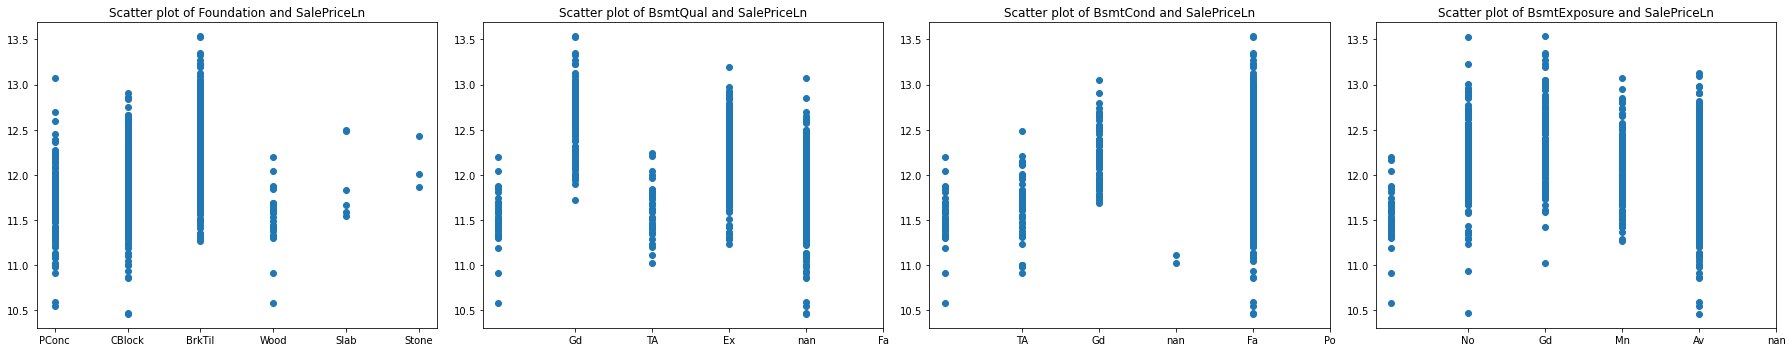

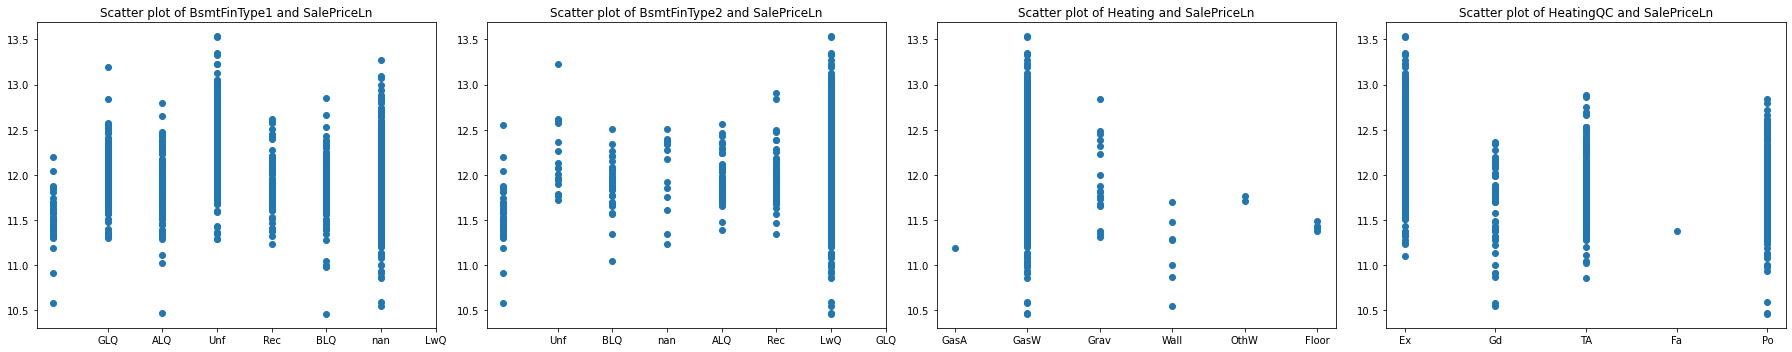

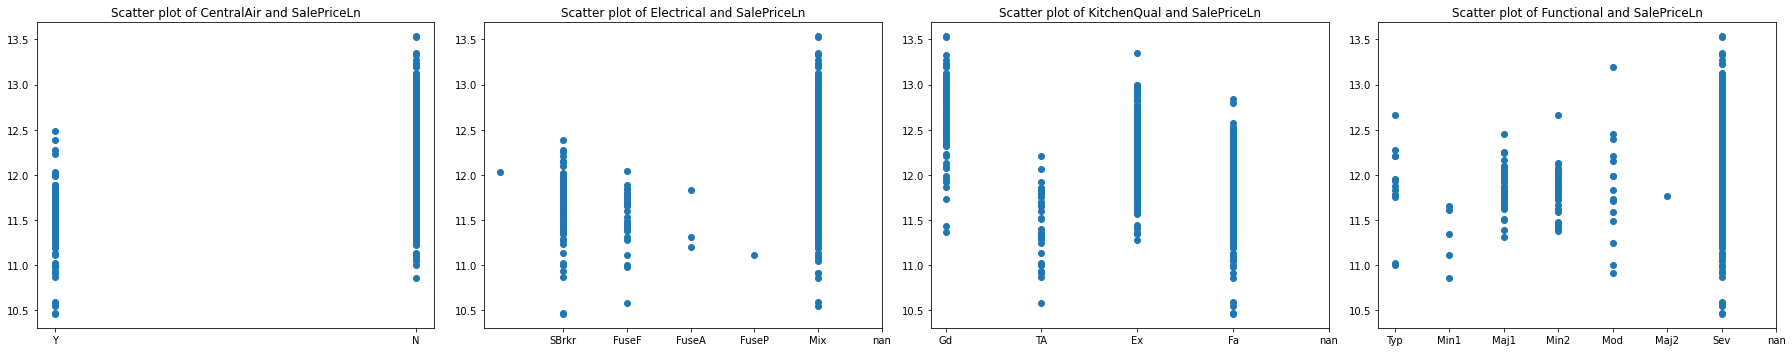

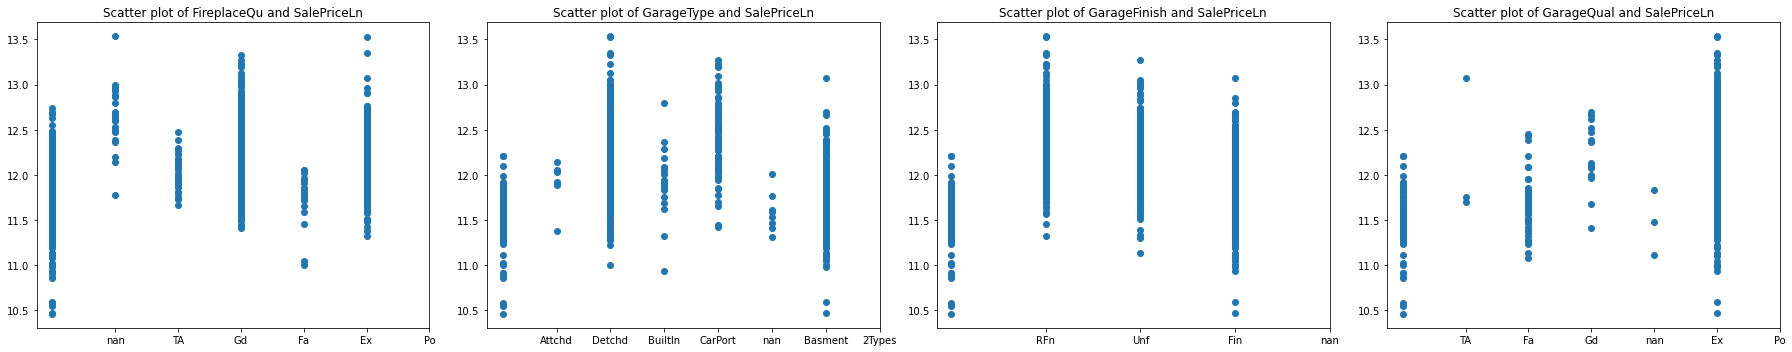

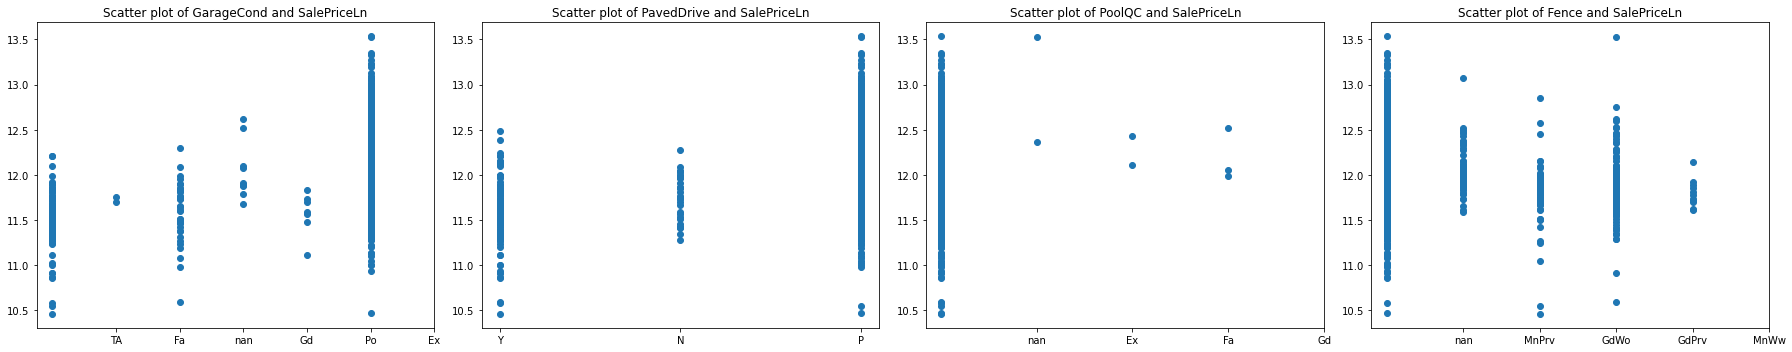

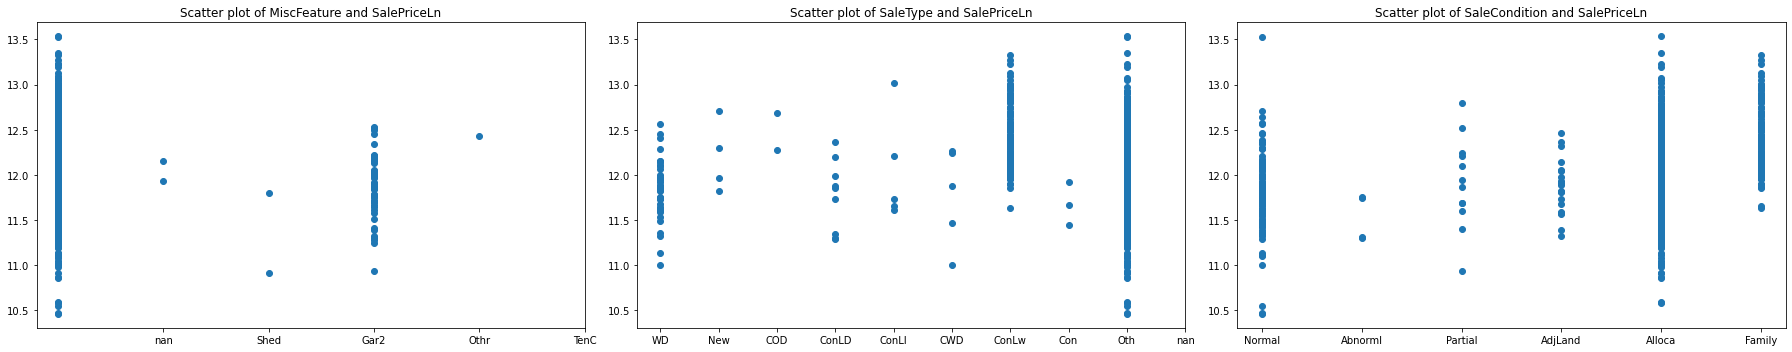

In [13]:
chart_gen('scatter', 0, 4, combined, ['OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea'], 'SalePriceLn')
chart_gen('scatter', 0, 4, combined, ['1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea'], 'SalePriceLn')
chart_gen('scatter', 0, 4, combined, ['BsmtFullBath', 'BsmtHalfBath', 'MoSold', 'BsmtFinSF1'], 'SalePriceLn')
chart_gen('scatter', 0, 4, combined, ['BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'FullBath'], 'SalePriceLn')
chart_gen('scatter', 0, 4, combined, ['HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd'], 'SalePriceLn')
chart_gen('scatter', 0, 4, combined, ['Fireplaces', 'YrSold', 'GarageYrBlt', 'GarageCars'], 'SalePriceLn')
chart_gen('scatter', 0, 4, combined, ['GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch'], 'SalePriceLn')
chart_gen('scatter', 0, 5, combined, ['3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MSSubClass'], 'SalePriceLn')
chart_gen('scatter-string', 0, 4, combined, ['MSZoning', 'Street', 'Alley', 'LotShape'], 'SalePriceLn')
chart_gen('scatter-string', 0, 4, combined, ['LandContour', 'Utilities', 'LotConfig', 'LandSlope'], 'SalePriceLn')
chart_gen('scatter-string', 0, 4, combined, ['Neighborhood', 'Condition1', 'Condition2', 'BldgType'], 'SalePriceLn')
chart_gen('scatter-string', 0, 4, combined, ['HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st'], 'SalePriceLn')
chart_gen('scatter-string', 0, 4, combined, ['Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond'], 'SalePriceLn')
chart_gen('scatter-string', 0, 4, combined, ['Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure'], 'SalePriceLn')
chart_gen('scatter-string', 0, 4, combined, ['BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC'], 'SalePriceLn')
chart_gen('scatter-string', 0, 4, combined, ['CentralAir', 'Electrical', 'KitchenQual', 'Functional'], 'SalePriceLn')
chart_gen('scatter-string', 0, 4, combined, ['FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual'], 'SalePriceLn')
chart_gen('scatter-string', 0, 4, combined, ['GarageCond', 'PavedDrive', 'PoolQC', 'Fence'], 'SalePriceLn')
chart_gen('scatter-string', 0, 3, combined, ['MiscFeature', 'SaleType', 'SaleCondition'], 'SalePriceLn')

### Missing Values

commentary

In [14]:
# Determine how many NAN values each observation has
combined['nan'] = 0
for i in range(0, len(combined)):
    combined.loc[i, 'nan'] = combined.loc[i, :].isnull().sum().sum()

print("Value Counts of the # of NaN's in an observation:")
print(combined['nan'].value_counts().sort_values(ascending=False))

Value Counts of the # of NaN's in an observation:
6     691
4     649
5     637
7     497
3     132
8      69
10     64
12     54
9      41
11     39
2      16
13     10
14      6
17      6
15      5
1       2
18      1
Name: nan, dtype: int64


In [15]:
# Obtain the name of the column and number of missing values

missing_values = pd.DataFrame(columns = ['Column Name', '# NaN'])

for i in range(0, len(combined.columns)):
    count = combined.iloc[:, i].isnull().sum()
    if count > 0:
        new_row = {'Column Name': combined.columns[i], '# NaN': count}
        missing_values = missing_values.append(new_row, ignore_index=True)

In [16]:
missing_values

,Column Name,# NaN
0,MSZoning,4
1,LotFrontage,486
2,Alley,2721
3,Utilities,2
4,Exterior1st,1
5,Exterior2nd,1
6,MasVnrType,24
7,MasVnrArea,23
8,BsmtQual,81
9,BsmtCond,82


## Preprocessing

The following steps first deal with missing data, then feature creation, dummy variables for categorical variables, and correlation heat maps to down-select features to include in the model.

#### Outliers

There appears to be potential outliers with LotArea, MasVnrArea, BsmtFinSF1, BsmtFinSF2, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GarageYrBuilt, WoodDeckSF, OpenPorchSF, and EnclosedPorch which might be miscoded.

I tackle outliers in the modeling stage by looking at studentized residuals, leverage, and Cook's Distance Method to determine the influence each observation has on the model.

In [17]:
outlier_vars = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GarageYrBlt', 
                'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch']

for i in outlier_vars:
    print(i)
    print(combined[i].describe())

LotArea
count      2919.000000
mean      10168.114080
std        7886.996359
min        1300.000000
25%        7478.000000
50%        9453.000000
75%       11570.000000
max      215245.000000
Name: LotArea, dtype: float64
MasVnrArea
count    2896.000000
mean      102.201312
std       179.334253
min         0.000000
25%         0.000000
50%         0.000000
75%       164.000000
max      1600.000000
Name: MasVnrArea, dtype: float64
BsmtFinSF1
count    2918.000000
mean      441.423235
std       455.610826
min         0.000000
25%         0.000000
50%       368.500000
75%       733.000000
max      5644.000000
Name: BsmtFinSF1, dtype: float64
BsmtFinSF2
count    2918.000000
mean       49.582248
std       169.205611
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1526.000000
Name: BsmtFinSF2, dtype: float64
TotalBsmtSF
count    2918.000000
mean     1051.777587
std       440.766258
min         0.000000
25%       793.000000
50%       989.500000
75% 

In [39]:
# Check if the basement outliers and other outlier groupings are the same group.

check = combined[(combined['LotArea'] == combined['LotArea'].max()) | (combined['MasVnrArea'] == combined['MasVnrArea'].max()) | 
                 (combined['BsmtFinSF1'] == combined['BsmtFinSF1'].max()) | (combined['BsmtFinSF2'] == combined['BsmtFinSF2'].max()) | 
                 (combined['TotalBsmtSF'] == combined['TotalBsmtSF'].max()) | (combined['1stFlrSF'] == combined['1stFlrSF'].max()) | 
                 (combined['2ndFlrSF'] == combined['2ndFlrSF'].max()) | (combined['LowQualFinSF'] == combined['LowQualFinSF'].max()) | 
                 (combined['GarageYrBlt'] == combined['GarageYrBlt'].max()) | (combined['WoodDeckSF'] == combined['WoodDeckSF'].max()) | 
                 (combined['OpenPorchSF'] == combined['OpenPorchSF'].max()) | (combined['EnclosedPorch'] == combined['EnclosedPorch'].max())]

The issue is that of the 11 observations exhibiting these outliers, only 4 of them are within the training set index, the other 7 are within the test set. 
Look at observation 297, its MasVnrArea is the max value. However, its not too far removed so I'll keep it for now. In the modeling stage I may drop it.
Looking at observation 313, it has a massive lot area. Considering the garage was was in 1965, it is feasible that this is a valid observation. However, its such an extreme outlier (especially considering its SalePrice) that I'll drop it. 
Looking at observation 1182, it has the max value for 2ndFlrSF. Its not too far removed so I'll keep it for now. In the modeling stage I may drop it.
Looking at observation 1298, it has the max BsmtFinSF1. Its an extreme outlier (especially considering its salePrice) so I'll drop it.

For the test observations, I don't see any observations where I can impute a clear miscoding except for 2592, GarageYrBlt. I'll change that to 2007.

In [40]:
check[['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GarageYrBlt', 
      'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'SalePrice', 'OverallCond']]

,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GarageYrBlt,WoodDeckSF,OpenPorchSF,EnclosedPorch,SalePrice,OverallCond
297,7399,1600.0,649.0,0.0,975.0,975,975,0,1997.0,0,10,0,239000.0,5
313,215245,0.0,1236.0,820.0,2136.0,2036,0,0,1965.0,0,0,0,375000.0,5
1182,15623,0.0,2096.0,0.0,2396.0,2411,2065,0,1996.0,171,78,0,745000.0,5
1298,63887,796.0,5644.0,0.0,6110.0,4692,950,0,2008.0,214,292,0,160000.0,5
1698,10750,634.0,236.0,1526.0,2024.0,2063,0,0,1994.0,182,56,0,NaN,5
1785,10410,0.0,0.0,0.0,1313.0,1313,0,1064,1954.0,0,0,432,NaN,5
2503,23920,0.0,0.0,0.0,1105.0,1105,717,0,1984.0,0,195,1012,NaN,5
2549,39290,1224.0,4010.0,0.0,5095.0,5095,0,0,2008.0,546,484,0,NaN,5
2557,10890,0.0,371.0,0.0,1296.0,1296,1296,0,NaN,0,742,240,NaN,6
2592,8298,NaN,583.0,0.0,1546.0,1564,0,0,2207.0,132,0,0,NaN,5


In [139]:
combined.loc[combined['GarageYrBlt'] == 2207, 'GarageYrBlt'] = 2007
combined_dropped = combined.drop(index=[313, 1298])

#### Missing Data

##### Variables: Fence, MiscFeature, PoolQC, FireplaceQu, and Alley

I tackle Fence, MiscFeature, PoolQC, FireplaceQu, Alley in a grouping since these five consist of the most missing values by a wide margin and all their NaNs should be recoded as "None"

In [140]:
for i in ['Fence', 'MiscFeature', 'PoolQC', 'FireplaceQu', 'Alley']:
    combined_dropped[i] = combined_dropped[i].fillna('None')

##### Variables: GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond, GarageCars, GarageArea

I tackle garage related variables in a single grouping. Looking at data_description.txt, all their NaNs should be recoded as "None" to represent the property not having a garage.

In [141]:
for i in ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']:
    combined_dropped[i] = combined_dropped[i].fillna('None')

I examine the observations that are missing GarageCars and GarageArea

In [142]:
garage_check = combined_dropped[(pd.isna(combined_dropped['GarageCars'])) | (pd.isna(combined_dropped['GarageArea']))]

Since this observation only has one garage variable that has a valid value (all others were recorded as NA) I assume that listing the garage as detached was a mistake and should be None as well.

In [143]:
garage_check[['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageCars', 'GarageArea']]

,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,GarageCars,GarageArea
2576,Detchd,None,None,None,None,NaN,NaN


In [144]:
combined_dropped.loc[2576, 'GarageType'] = 'None'
combined_dropped.loc[2576, 'GarageCars'] = 0
combined_dropped.loc[2576, 'GarageArea'] = 0

##### Variables: BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF

I tackle basement related variables in a single grouping. Looking at data_description.txt, most of these observations NaNs should be recoded as "None" to represent the property not having a basement.

I first tackle TotalBsmtSF. There is only one missing value and Once I have solved that, I can determine if the other basement observations should have values or not. I use the most common value for that variable as the imputation

In [145]:
check_totsf = combined_dropped[pd.isna(combined_dropped['TotalBsmtSF']) == True]

Since all basement values are NA, I'll assume this house doesn't have a basement.

In [146]:
check_totsf[['TotalBsmtSF', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF']]

,TotalBsmtSF,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF
2120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:
combined_dropped.loc[pd.isna(combined_dropped['TotalBsmtSF']) == True, 'TotalBsmtSF'] = 0

In [148]:
combined_dropped.loc[(combined_dropped['TotalBsmtSF'] == 0) & (pd.isna(combined_dropped['BsmtQual']) == True), 'BsmtQual'] = 'None'
combined_dropped.loc[(combined_dropped['TotalBsmtSF'] > 0) & (pd.isna(combined_dropped['BsmtQual']) == True), 'BsmtQual'] = 'TA'

In [149]:
combined_dropped.loc[(combined_dropped['TotalBsmtSF'] == 0) & (pd.isna(combined_dropped['BsmtCond']) == True), 'BsmtCond'] = 'None'
combined_dropped.loc[(combined_dropped['TotalBsmtSF'] > 0) & (pd.isna(combined_dropped['BsmtCond']) == True), 'BsmtCond'] = 'TA'

In [150]:
combined_dropped.loc[(combined_dropped['TotalBsmtSF'] == 0) & (pd.isna(combined_dropped['BsmtExposure']) == True), 'BsmtExposure'] = 'None'
combined_dropped.loc[(combined_dropped['TotalBsmtSF'] > 0) & (pd.isna(combined_dropped['BsmtExposure']) == True), 'BsmtExposure'] = 'No'

In [151]:
combined_dropped.loc[(combined_dropped['TotalBsmtSF'] == 0) & (pd.isna(combined_dropped['BsmtFinType1']) == True), 'BsmtFinType1'] = 'None'
combined_dropped.loc[(combined_dropped['TotalBsmtSF'] > 0) & (pd.isna(combined_dropped['BsmtFinType1']) == True), 'BsmtFinType1'] = 'Unf'

In [152]:
combined_dropped.loc[(combined_dropped['TotalBsmtSF'] == 0) & (pd.isna(combined_dropped['BsmtFinSF1']) == True), 'BsmtFinSF1'] = 0
combined_dropped.loc[(combined_dropped['TotalBsmtSF'] > 0) & (pd.isna(combined_dropped['BsmtFinSF1']) == True), 'BsmtFinSF1'] = combined_dropped['TotalBsmtSF'].median()

In [153]:
combined_dropped.loc[(combined_dropped['TotalBsmtSF'] == 0) & (pd.isna(combined_dropped['BsmtFinType2']) == True), 'BsmtFinType2'] = 'None'
combined_dropped.loc[(combined_dropped['TotalBsmtSF'] > 0) & (pd.isna(combined_dropped['BsmtFinType2']) == True), 'BsmtFinType2'] = 'Unf'

In [154]:
combined_dropped.loc[pd.isna(combined_dropped['BsmtFinSF2']) == True, 'BsmtFinSF2'] = 0

In [155]:
combined_dropped.loc[pd.isna(combined_dropped['BsmtUnfSF']) == True, 'BsmtUnfSF'] = 0

##### Variable: Electrical

There is only one missing observation so I insert the most common value, in this case SBrkr which is found in 91.2% of all homes in the data set.

In [162]:
combined_dropped['Electrical'].value_counts()

SBrkr    2669
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [163]:
combined_dropped.loc[pd.isna(combined_dropped['Electrical']) == True, 'Electrical'] = 'SBrkr'

##### Variables: MasVnrType and MasVnrArea

To impute the values for MasVnrType and MasVnrArea, I use the median value, which in this case is no masonry and thus 0 area.

In [166]:
print(combined_dropped['MasVnrType'].value_counts())
print(combined_dropped['MasVnrArea'].value_counts())

combined_dropped.loc[pd.isna(combined_dropped['MasVnrType']) == True, 'MasVnrType'] = 'None'
combined_dropped.loc[pd.isna(combined_dropped['MasVnrArea']) == True, 'MasVnrArea'] = 0.0

None       1765
BrkFace     879
Stone       248
BrkCmn       25
Name: MasVnrType, dtype: int64
0.0      1760
120.0      15
176.0      13
200.0      13
180.0      12
         ... 
788.0       1
391.0       1
604.0       1
428.0       1
382.0       1
Name: MasVnrArea, Length: 443, dtype: int64


##### Variable: LotFrontage

Since there are other Lot variables, such as LotArea, LotShape, and LotConfig, I drop LotFrontage. The assumption is that these three variables will share some of the same explanation to the dependent variable variance as LotFrontage. Additionally, with 400+ missing values, the imputation would have low accuracy.

In [169]:
combined_dropped.drop(columns = ['LotFrontage'], axis = 1, inplace = True)

##### Variables: MSZoning, Utilites, Exterior1st, Exterior2nd, BsmtFullBath, BsmtHalfBath, KitchenQual, Functiona, SaleType

For these variables, since there are less than 5 missing in each column, I just use the most common value

In [180]:
combined_dropped['SaleType'].value_counts()

WD       2524
New       238
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

In [181]:
combined_dropped.loc[pd.isna(combined_dropped['MSZoning']) == True, 'MSZoning'] = 'RL'
combined_dropped.loc[pd.isna(combined_dropped['Utilities']) == True, 'Utilities'] = 'AllPub'
combined_dropped.loc[pd.isna(combined_dropped['Exterior1st']) == True, 'Exterior1st'] = 'VinylSd'
combined_dropped.loc[pd.isna(combined_dropped['Exterior2nd']) == True, 'Exterior2nd'] = 'VinylSd'
combined_dropped.loc[pd.isna(combined_dropped['BsmtFullBath']) == True, 'BsmtFullBath'] = 0.0
combined_dropped.loc[pd.isna(combined_dropped['BsmtHalfBath']) == True, 'BsmtHalfBath'] = 0.0
combined_dropped.loc[pd.isna(combined_dropped['KitchenQual']) == True, 'KitchenQual'] = 'TA'
combined_dropped.loc[pd.isna(combined_dropped['Functional']) == True, 'Functional'] = 'Typ'
combined_dropped.loc[pd.isna(combined_dropped['SaleType']) == True, 'SaleType'] = 'WD'

#### New Features

remod is just the value of the year - create var where if the difference is 0, have it 1/0 dummy and then create dummies for the actual years

#### Correlation Heat Maps

#### Split Training & Test

drop Id variable after I split them

#### Scaling

## Modeling

## Conclusion